# Chapter 4: Long/Short Methodologies: Absolute and Relative

This chapter introduces the relative series methodology
1. Import libraries
2. Bullish/Bearish stocks in the S&P500 in absolute & relative series
3. Relative function
4. Examples of absolute and relative series

### Import Libraries

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

### S&P500 stocks making 1 year high (bullish)/ low (bearish) in absolute/relative series
The following chart shows the S&P 500 index and a count of all the constituents in either the bull or bear regime using the absolute price series.

Indices such as S&P 500, Nasdaq 100, FTSE 100, and Topix are the market capitalization weighted average of their constituents. Roughly half the stocks will do better and the rest worse than the index over any timeframe. 

<ipython-input-3-7be6a598dc1b>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-')


['^GSPC', 'MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN'] 0 20
[*********************100%***********************]  20 of 20 completed
['ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN'] 20 40
[*********************100%***********************]  20 of 20 completed
['APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL'] 40 60
[*********************100%***********************]  20 of 20 completed
['BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR'] 60 80
[*********************100%***********************]  20 of 20 completed
['BRO', 'BF-B', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBO

<AxesSubplot:title={'center':'S&P500, 1yr High/Low count: absolute & relative series'}, xlabel='Date'>

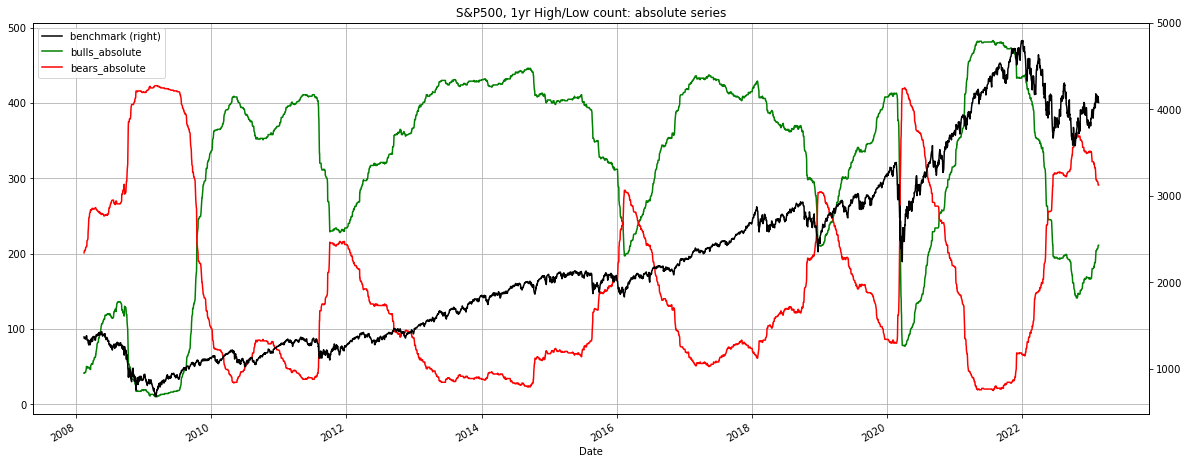

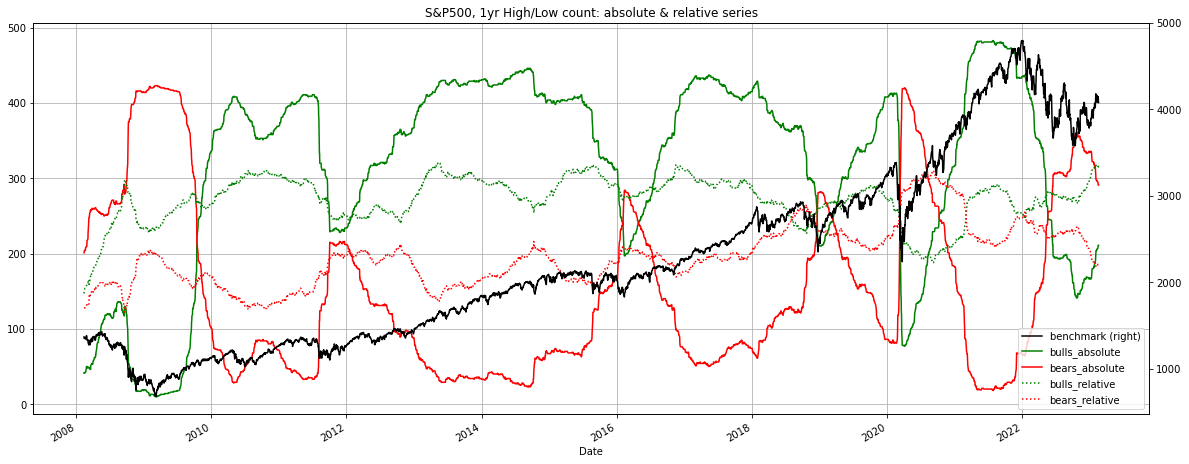

In [3]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

import yfinance as yf 
# S&P500 dataframe: list of tickers
sp_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-')
bm_ticker = '^GSPC'
tickers_list = [bm_ticker] + list(sp_df['Symbol'])[:]

# Variables instantiation
window = 252
show_batch = True
df_abs = pd.DataFrame()
batch_size = 20
loop_size = int(len(tickers_list) // batch_size) + 2

for t in range(1,loop_size): # Batch download
    m = (t - 1) * batch_size
    n = t * batch_size
    batch_list = tickers_list[m:n]
    print(batch_list,m,n)
    batch_download = yf.download(tickers= batch_list,start= '2007-01-01', end = None, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
    df_abs = df_abs.join(batch_download, how='outer')
    
bullbear = pd.DataFrame()
bullbear['benchmark'] = round(df_abs[bm_ticker].copy(),2)    
df_rel = round(df_abs.divide(df_abs[bm_ticker], axis=0).mul(df_abs[bm_ticker][0]),1)
df_rel = pd.DataFrame(data=np.where(df_rel >= df_rel.rolling(window).max(),1,
        np.where(df_rel <= df_rel.rolling(window).min(),-1,np.nan)), 
            index=df_rel.index,columns=df_rel.columns).fillna(method='ffill')
df_abs = pd.DataFrame(data=np.where(df_abs >= df_abs.rolling(window).max(),1,
        np.where(df_abs<=df_abs.rolling(window).min(),-1,np.nan)), 
            index=df_abs.index,columns=df_abs.columns).fillna(method='ffill')

bullbear['bulls_absolute'] = df_abs[df_abs > 0].count(axis=1) 
bullbear['bears_absolute'] = df_abs[df_abs < 0].count(axis=1) 
bullbear['bulls_relative'] = df_rel[df_rel > 0].count(axis=1) 
bullbear['bears_relative'] = df_rel[df_rel < 0].count(axis=1) 

bullbear[280:][['benchmark','bulls_absolute', 'bears_absolute', 
               ]].plot(figsize=(20,8),
                style=['k', 'g', 'r'],grid=True,secondary_y=['benchmark'],
                title = 'S&P500, 1yr High/Low count: absolute series' )

bullbear[280:][['benchmark','bulls_absolute', 'bears_absolute', 'bulls_relative', 'bears_relative']].plot(figsize=(20,8),
                style=['k', 'g', 'r','g:', 'r:'],grid=True,secondary_y=['benchmark'],
                title = 'S&P500, 1yr High/Low count: absolute & relative series')

### Relative function

In [4]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

### RELATIVE
def relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=True):
    '''
    df: df
    bm_df, bm_col: df benchmark dataframe & column name
    ccy_df,ccy_col: currency dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    rebase: boolean rebase to beginning or continuous series
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end] 
    
    # inner join of benchmark & currency: only common values are preserved
    df = df.join(bm_df[[bm_col]],how='inner') 
    df = df.join(ccy_df[[ccy_col]],how='inner')

    # rename benchmark name as bm and currency as ccy
    df.rename(columns={bm_col:'bm', ccy_col:'ccy'},inplace=True)

    # Adjustment factor: calculate the scalar product of benchmark and currency
    df['bmfx'] = round(df['bm'].mul(df['ccy']),dgt).fillna(method='ffill')
    if rebase == True:
        df['bmfx'] = df['bmfx'].div(df['bmfx'][0])

    # Divide absolute price by fxcy adjustment factor and rebase to first value
    df['r' + str(_o)] = round(df[_o].div(df['bmfx']),dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bmfx']),dgt)
    df['r'+ str(_l)] = round(df[_l].div(df['bmfx']),dgt)
    df['r'+ str(_c)] = round(df[_c].div(df['bmfx']),dgt)
    df = df.drop(['bm','ccy','bmfx'],axis=1)
    
    return (df)

### RELATIVE ###



### Softbank in absolute JPY & relative to Nasdaq in USD

Softbank (9984.T) is a company listed on the Tokyo Stock Exchange (TSE). It trades in Japanese yen. The company has been a major player in the US tech industry for almost three decades. Softbank will be benchmarked against Nasdaq in USD

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Softbank Absolute in JPY vs relative to Nasdaq in USD rebased'}, xlabel='Date'>

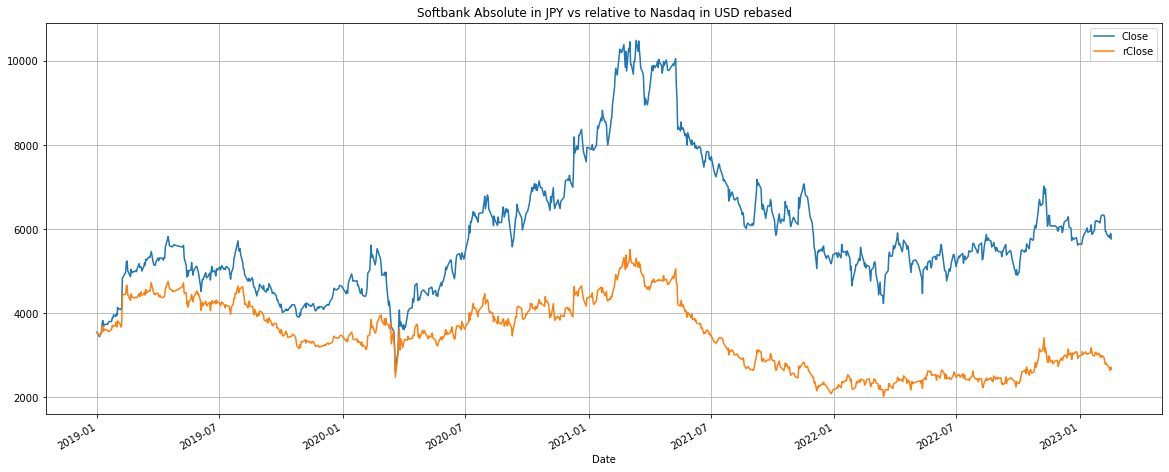

In [5]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

ticker = '9984.T' # Softbank
ohlc = ['Open','High','Low','Close']
_o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
start= '2018-12-30'
end = None
df =  round(yf.download(tickers= ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None),2)
bm_df = pd.DataFrame()
bm_ticker = '^IXIC' #Nasdaq 
bm_col = 'nasdaq'
ccy_df = pd.DataFrame()
ccy_ticker = 'USDJPY=X'
ccy_col = 'JPY'
dgt = 5

bm_df[bm_col] =  yf.download(tickers= bm_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
ccy_df[ccy_col] =  yf.download(tickers= ccy_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']

df = relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=True)

df[['Close','rClose']].plot(figsize=(20,8),grid=True,
            title= 'Softbank Absolute in JPY vs relative to Nasdaq in USD rebased' )



Same data, but the relative series is not rebased to the beginning of the series

<AxesSubplot:title={'center':'Softbank Absolute in JPY vs relative to Nasdaq in USD'}, xlabel='Date'>

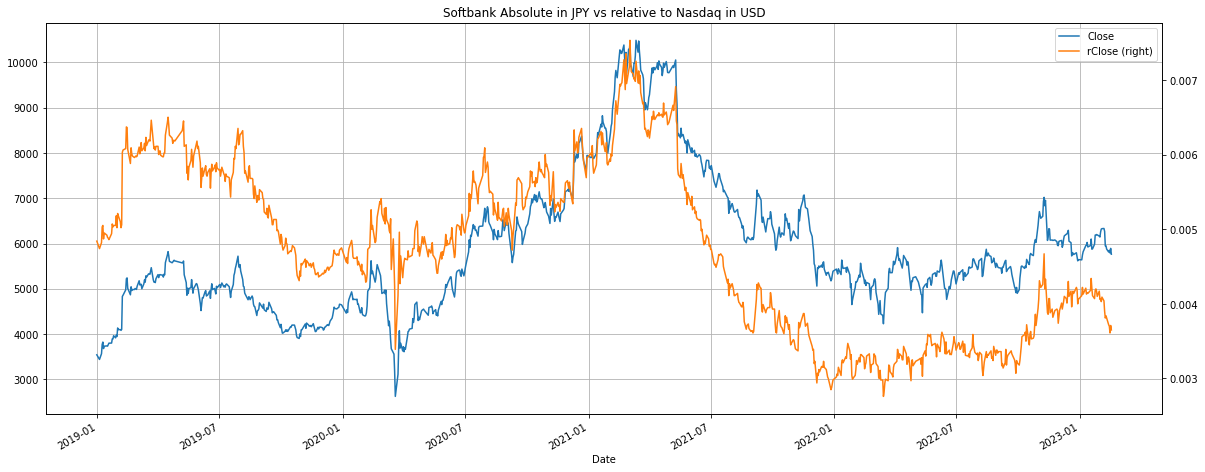

In [6]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative


# Not included in the book

df2 = relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=False)
df2[['Close','rClose']].plot(figsize=(20,8),grid=True,secondary_y= 'rClose',
            title= 'Softbank Absolute in JPY vs relative to Nasdaq in USD' )

### Comparison of three stocks across 3 different sectors


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'GEMS Absolute Prices vs Relative Series'}, xlabel='Date'>

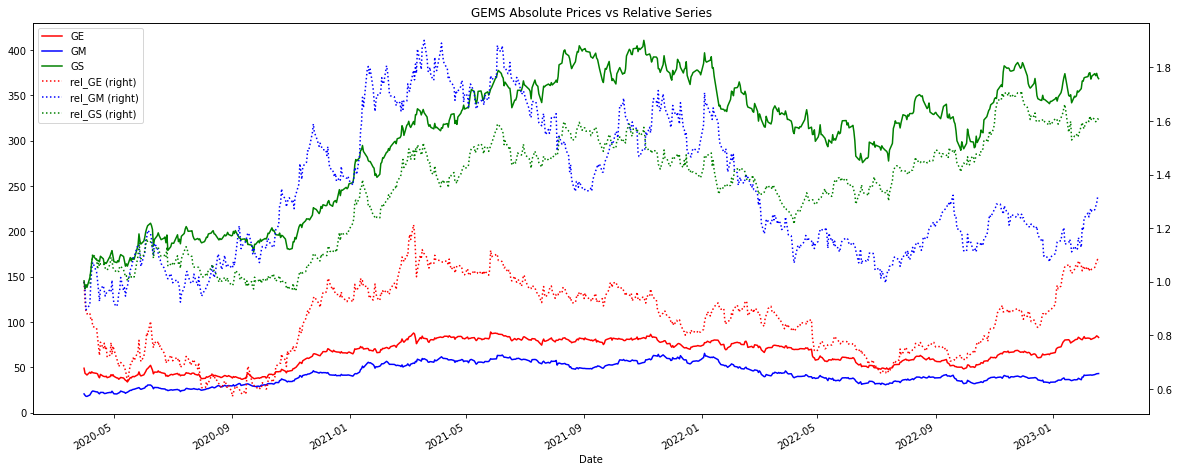

In [7]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

tickers_list = ['GE','GM','GS']

# Dataframes instantiation
gems = pd.DataFrame() 
start = '2020-03-31'
benchmark = yf.download(tickers= '^GSPC',start= start, end = None, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
failed = [] 
rel_ticker_list = []
for n,ticker in enumerate(tickers_list):
    try: #7 Download & process data
        gems[ticker] = yf.download(tickers= ticker,start= start, end = None, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
        gems['rel_'+ticker] = gems[ticker].div(benchmark * gems[ticker][0]) * benchmark[0]
        rel_ticker_list.append('rel_'+ticker)
    except:
        failed.append(ticker)
gems = gems[tickers_list+rel_ticker_list]
gems.plot(figsize= (20,8),secondary_y= rel_ticker_list,style=['r','b','g','r:','b:','g:'], 
          title= 'GEMS Absolute Prices vs Relative Series' )




### Wells Fargo 1 year before the scandal in absolute and relative

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:title={'center':'WFC Absolute vs Relative series'}, xlabel='Date'>

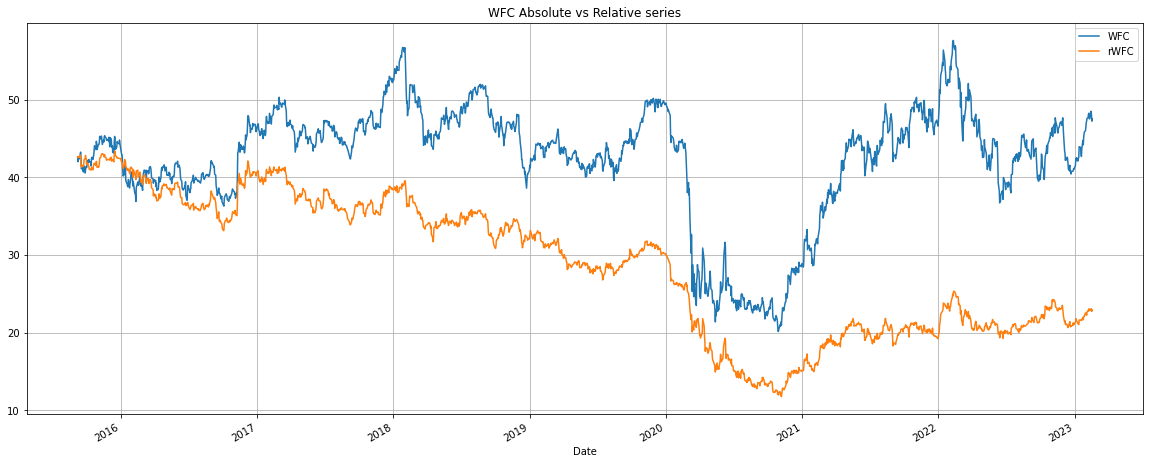

In [8]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

ticker = 'WFC'
benchmark = '^GSPC'
tickers_list = [benchmark] + [ticker]

data = round(yf.download(tickers= tickers_list,start= '2015-09-07', end = None,
            interval = "1d",group_by = 'column',auto_adjust = True, 
            prepost = True, treads = True, proxy = None)['Close'],2)

data['r'+str(ticker)] = round(data[ticker].div(data[benchmark])*data[benchmark][0] ,2)
data[[ticker,'r'+str(ticker)]].plot(figsize=(20,8),grid=True,
title= str.upper(ticker)+ ' Absolute vs Relative series')